<a href="https://colab.research.google.com/github/neethu-1983/Boosting-Techniques/blob/master/XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics.scorer import make_scorer

First up we'll download the last few years of load data from the Australian Energy Market Operator and narrow it down just the Trading Interval (datetime) and Metered Generation data.



In [0]:
%%time
df = pd.read_csv('http://data.wa.aemo.com.au/datafiles/load-summary/load-summary-2010.csv', parse_dates=['Trading Date','Trading Interval'])
for i in range(2011, 2020):
  df=df.append(pd.read_csv('http://data.wa.aemo.com.au/datafiles/load-summary/load-summary-'+str(i)+'.csv', 
                           parse_dates=['Trading Date','Trading Interval']))
df=df[['Trading Interval', 'Metered Generation (Total; MWh)']].dropna()

CPU times: user 570 ms, sys: 124 ms, total: 694 ms
Wall time: 46 s


A quick check of the data shows that it's in half hour time slots and that generation is measured in megawatt hours, you'll need to double these values if you're used to working in average megawatts.

In [0]:
df.insert(len(df.columns), 'hour', df['Trading Interval'].dt.hour + df['Trading Interval'].dt.minute/60)
df.insert(len(df.columns), 'weekday', df['Trading Interval'].dt.weekday)
df.insert(len(df.columns), 'month', df['Trading Interval'].dt.month)
df.insert(len(df.columns), 'year', df['Trading Interval'].dt.year)


In [0]:
%%time
max_temp = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1CHwEwl6A4uqRq_2Q6rtcoICqEMehYR1X&export=download')
min_temp = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1HJV8HtzRlTG_Tn12gUEPemqNt-4E-QWo&export=download')
temp = max_temp.merge(min_temp, left_on=['Year','Month','Day'], right_on=['Year','Month','Day']).dropna()
temp = temp[['Year','Month','Day','Maximum temperature (Degree C)', 'Minimum temperature (Degree C)']]
df.insert(len(df.columns), 'day', df['Trading Interval'].dt.day)
df = df.merge(temp, left_on=['year','month','day'], right_on=['Year','Month','Day']).drop(['day', 'Year', 'Month', 'Day'], axis=1)


CPU times: user 153 ms, sys: 11.9 ms, total: 165 ms
Wall time: 2.77 s


In [0]:
 %%time
temp['max_lag1'] = temp['Maximum temperature (Degree C)'].shift(periods=1)
temp['min_lag1'] = temp['Minimum temperature (Degree C)'].shift(periods=1)
temp['max_lag2'] = temp['Maximum temperature (Degree C)'].shift(periods=2)
temp['min_lag2'] = temp['Minimum temperature (Degree C)'].shift(periods=2)
df = df.drop(['Maximum temperature (Degree C)', 'Minimum temperature (Degree C)'], axis=1)
df.insert(len(df.columns), 'day', df['Trading Interval'].dt.day)
df = df.merge(temp, left_on=['year','month','day'], right_on=['Year','Month','Day']).drop(['day', 'Year', 'Month', 'Day'], axis=1)

CPU times: user 79.4 ms, sys: 2.95 ms, total: 82.4 ms
Wall time: 93.4 ms


In [0]:
df

,Trading Interval,Metered Generation (Total; MWh),hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2
0,2010-01-01 08:00:00,756.341197,8.0,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
1,2010-01-01 08:30:00,780.548255,8.5,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
2,2010-01-01 09:00:00,802.185847,9.0,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
3,2010-01-01 09:30:00,823.865739,9.5,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
4,2010-01-01 10:00:00,834.215943,10.0,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
...,...,...,...,...,...,...,...,...,...,...,...,...
172315,2020-01-01 05:30:00,830.035500,5.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172316,2020-01-01 06:00:00,786.106200,6.0,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172317,2020-01-01 06:30:00,810.694100,6.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172318,2020-01-01 07:00:00,734.017400,7.0,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9


Now let's define a few functions that we'll call as we val our new explanatory variables.

**train_test** takes a data frame, splits it into training and validation sets (based on a given number of records for the validation set)

In [0]:
def train_test(df, split_point):
  train_features = df.drop(['Metered Generation (Total; MWh)'], axis = 1).head(len(df)-split_point)
  train_labels = df['Metered Generation (Total; MWh)'].head(len(df)-split_point)
  val_features = df.drop(['Metered Generation (Total; MWh)'], axis = 1).tail(split_point)
  val_labels = df['Metered Generation (Total; MWh)'].tail(split_point)

  return [train_features, train_labels, val_features, val_labels]

**mean_Absolute_error** calculates mean absolute error

**check_predictions** sets up a 2x2 grid for subplots, and calls predictions_plot for all training and validation results, plus the last week of the training set and the first week of the validation set. 


**predictions_plot** used to plot our results

In [0]:
def mean_absolute_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true)))

my_scorer = make_scorer(mean_absolute_error)

In [0]:
train_features, train_labels, val_features, val_labels = train_test(df, 365*48)

In [0]:
#def predictions_plot(features=None, labels=[], ax=None):
 # if ax is None:
    # default/current plot
  #  ax = plt.gca()


#def check_predictions( train_features, train_labels, val_features, val_labels):
#  fig,axes  = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
#  predictions_plot(train_features, train_labels, axes[0,0])
#  predictions_plot(val_features, val_labels, axes[0,1])
#  predictions_plot( train_features.tail(7*48), train_labels.tail(7*48), axes[1,0])
#  predictions_plot( val_features.head(7*48), val_labels.head(7*48), axes[1,1])

In [0]:
val_features.tail(5)

Creating a baseline function with default parameters




In [0]:
def predictions_plot(model, features, labels, ax, drop_columns=['Trading Interval']):

  predictions = model.predict(features.drop(drop_columns, axis=1))
  errors = abs(predictions - labels)
  title='MAE:' + str(round(np.mean(errors), 2)) + \
        ' MAX_AE:' + str(round(np.max(abs(errors)), 2)) + \
        ' RMSE:' + str(round(np.sqrt(np.mean(np.square(errors))), 2))
  pd.DataFrame({'labels': labels, 
                'predictions': predictions, 
                'Trading Interval': features['Trading Interval']}).plot(title=title, ax=ax, x='Trading Interval')

def check_predictions(model, train_features, train_labels, val_features, val_labels, drop_columns=['Trading Interval']):
  fig,axes  = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
  fig.tight_layout(pad=6.0)
  predictions_plot(model, train_features, train_labels, axes[0,0], drop_columns=drop_columns)
  predictions_plot(model, val_features, val_labels, axes[0,1], drop_columns=drop_columns)
  predictions_plot(model, train_features.tail(7*48), train_labels.tail(7*48), axes[1,0], drop_columns=drop_columns)
  predictions_plot(model, val_features.head(7*48), val_labels.head(7*48), axes[1,1], drop_columns=drop_columns)

In [0]:
%%time
xg_reg = xgb.XGBRegressor(objective ='reg:linear')
xg_reg.fit(train_features.drop('Trading Interval', axis=1), train_labels)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[01:44:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6.01 s, sys: 156 ms, total: 6.17 s
Wall time: 6.82 s


In [0]:
%%time


val_preds = xg_reg.predict(val_features.drop('Trading Interval', axis=1))
print ("MSE_test: ", mean_absolute_error(val_labels,val_preds))

MSE_test:  81.72104936795448
CPU times: user 57.6 ms, sys: 19 µs, total: 57.6 ms
Wall time: 57.2 ms


In [0]:
%%time
train_preds = xg_reg.predict(train_features.drop('Trading Interval', axis=1))
print ("MSE_train ", mean_absolute_error(train_labels,train_preds))

MSE_train  50.43771306178609
CPU times: user 436 ms, sys: 3.9 ms, total: 439 ms
Wall time: 438 ms


In [0]:
xg_reg.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

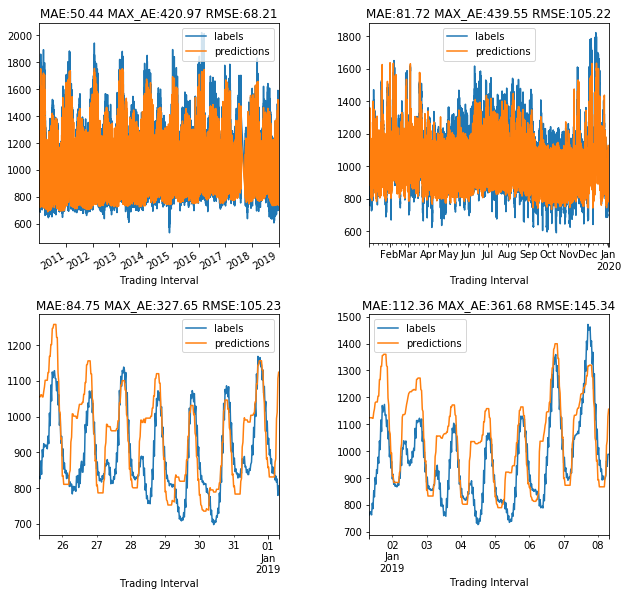

In [0]:
check_predictions(xg_reg, train_features, train_labels, val_features, val_labels)

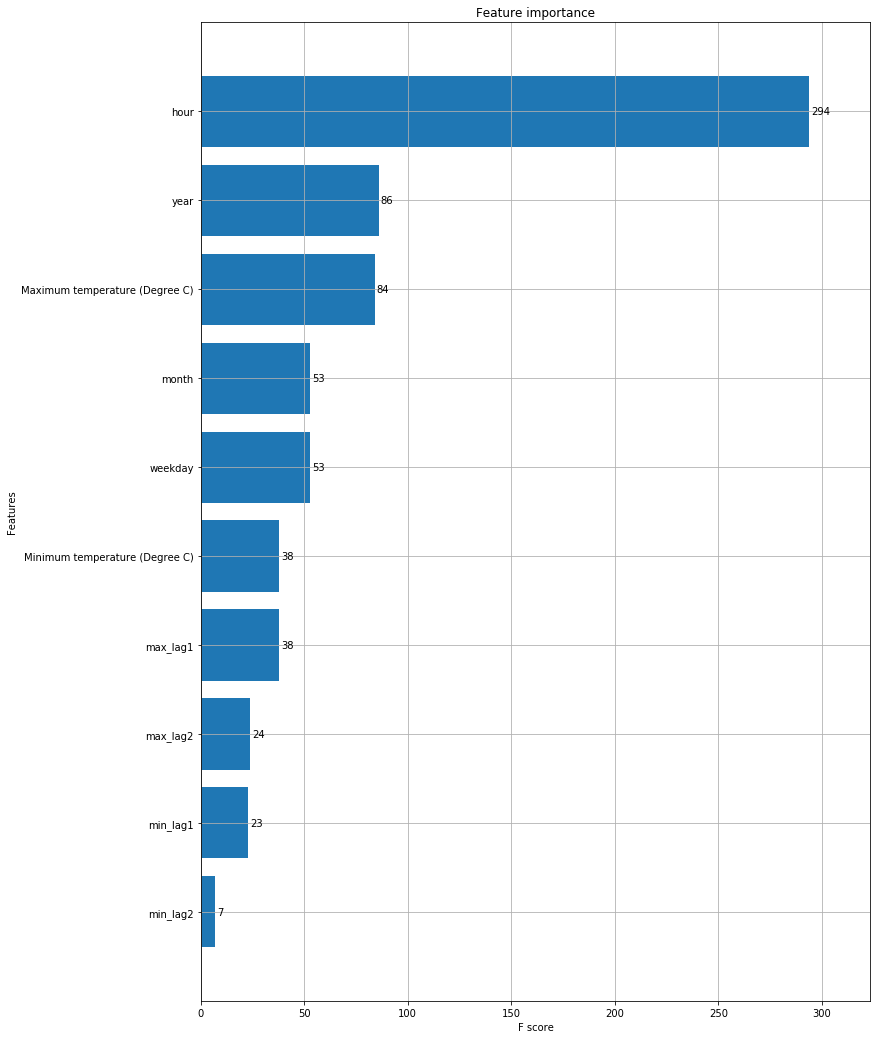

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xg_reg,  height=0.8, ax=ax)
plt.show()

LIGHTGBM

In [0]:
import lightgbm as ltb

In [0]:
train_data = ltb.Dataset(train_features.drop('Trading Interval', axis=1), label=train_labels)
test_data = ltb.Dataset(val_features.drop('Trading Interval', axis=1), label=val_labels)

In [0]:
%%time
parameters = {
   
    'objective':'regression',
    'metric': 'mae',
     'boosting': 'gbdt',
     'feature_fraction': 1,
    'bagging_fraction': 1,
    'learning_rate': 0.1,
    
}

l_model = ltb.train(parameters,
                       train_data,
                       valid_sets=test_data , verbose_eval = False                      
                       )


CPU times: user 2.33 s, sys: 26.5 ms, total: 2.36 s
Wall time: 1.23 s


In [0]:
train_pred_lgb = l_model.predict(train_features)
print (mean_absolute_error(train_labels,train_pred_lgb))

34.649217546057756


In [0]:
%%time
    val_pred_lgb = l_model.predict(val_features.drop('Trading Interval', axis=1))
print (mean_absolute_error(val_labels,val_pred_lgb))

57.01665567263015
CPU times: user 91.4 ms, sys: 0 ns, total: 91.4 ms
Wall time: 94.9 ms


In [0]:
%%time
parameters = {
   
    'objective':'regression',
    'metric': 'mae',
    'boosting': 'rf',
    'bagging_fraction' : 0.8,
    'bagging_freq': 10,
    'feature_fraction' : 0.8,
    'learning_rate': 0.21,
    'num_trees':100
     }

l_model_rf = ltb.train(parameters,
                       train_data,
                       valid_sets=test_data                      
                       )


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 94.9812
[2]	valid_0's l1: 94.9812
[3]	valid_0's l1: 91.2403
[4]	valid_0's l1: 88.0948
[5]	valid_0's l1: 85.6647
[6]	valid_0's l1: 85.5679
[7]	valid_0's l1: 85.0168
[8]	valid_0's l1: 85.3023
[9]	valid_0's l1: 85.3771
[10]	valid_0's l1: 85.5402
[11]	valid_0's l1: 85.567
[12]	valid_0's l1: 85.8793
[13]	valid_0's l1: 85.3303
[14]	valid_0's l1: 85.1763
[15]	valid_0's l1: 85.1836
[16]	valid_0's l1: 85.5801
[17]	valid_0's l1: 85.4199
[18]	valid_0's l1: 85.0828
[19]	valid_0's l1: 84.8855
[20]	valid_0's l1: 84.9392
[21]	valid_0's l1: 84.9556
[22]	valid_0's l1: 84.9944
[23]	valid_0's l1: 85.0944
[24]	valid_0's l1: 85.183
[25]	valid_0's l1: 85.2628
[26]	valid_0's l1: 85.1433
[27]	valid_0's l1: 85.1765
[28]	valid_0's l1: 84.9633
[29]	valid_0's l1: 84.9848
[30]	valid_0's l1: 84.9732
[31]	valid_0's l1: 84.8988
[32]	valid_0's l1: 84.9111
[33]	valid_0's l1: 84.8953
[34]	valid_0's l1: 85.1157
[35]	valid_0's l1: 85.5241
[36]	valid_0's l1: 85.8953
[37]	valid_0's l1: 85.8114
[38]	valid_0

In [0]:
 val_pred_lgb_rf = l_model_rf.predict(val_features.drop('Trading Interval', axis=1))
print (mean_absolute_error(val_labels,val_pred_lgb_rf))

85.04627919161989


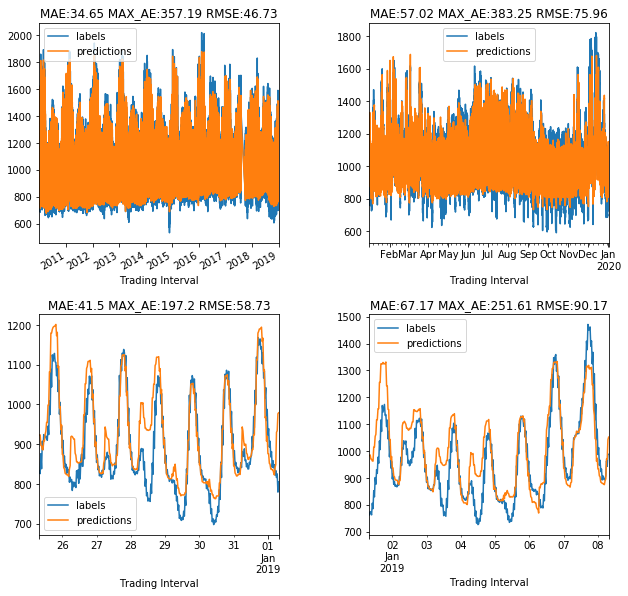

In [0]:
check_predictions(l_model, train_features, train_labels, val_features, val_labels)

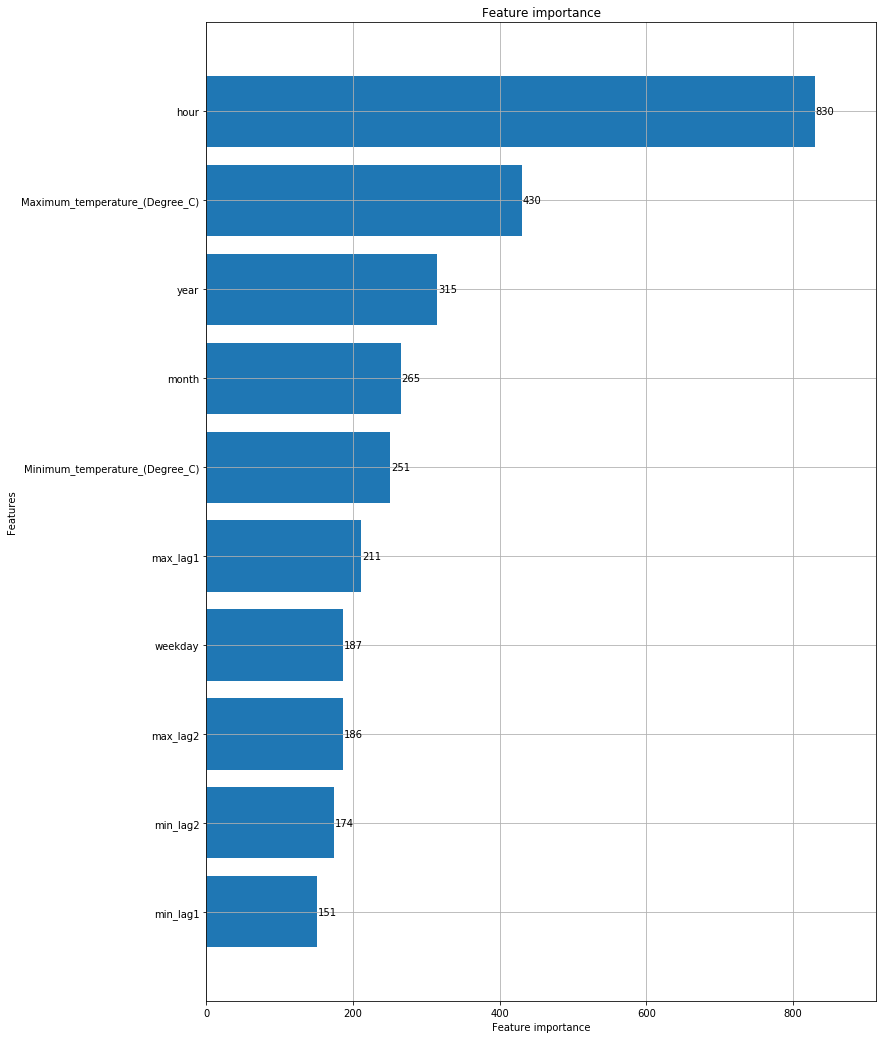

In [0]:

fig, ax = plt.subplots(figsize=(12,18))
ltb.plot_importance(l_model,  height=0.8, ax=ax)
plt.show()


**CATBOOST**

In [0]:
pip install catboost

     |████████████████████████████████| 64.4MB 45kB/s 


In [0]:
import catboost as cg

In [0]:
%%time

cat_boost = cg.CatBoostRegressor().fit(train_features, train_labels, verbose=0)

CPU times: user 42.8 s, sys: 2.52 s, total: 45.4 s
Wall time: 23.7 s


In [0]:
print(cat_boost.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 0, 'depth': 6, 'border_count': 254, 'classes_count': 0, 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.09575899690389632, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'MVS', 'max_leaves': 64}


In [0]:
train_pred_ctb = cat_boost.predict(train_features)
print (mean_absolute_error(train_labels,train_pred_ctb))

25.195020101799134


In [0]:
val_pred_ctb = cat_boost.predict(val_features)
print (mean_absolute_error(val_labels,val_pred_ctb))

53.08442978076165


In [0]:
train_features

,Trading Interval,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2
0,2010-01-01 08:00:00,8.0,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
1,2010-01-01 08:30:00,8.5,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
2,2010-01-01 09:00:00,9.0,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
3,2010-01-01 09:30:00,9.5,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
4,2010-01-01 10:00:00,10.0,4,1,2010,31.3,13.2,27.6,15.2,25.5,17.9
...,...,...,...,...,...,...,...,...,...,...,...
154795,2019-01-01 05:30:00,5.5,1,1,2019,34.1,16.3,32.2,13.9,29.7,11.7
154796,2019-01-01 06:00:00,6.0,1,1,2019,34.1,16.3,32.2,13.9,29.7,11.7
154797,2019-01-01 06:30:00,6.5,1,1,2019,34.1,16.3,32.2,13.9,29.7,11.7
154798,2019-01-01 07:00:00,7.0,1,1,2019,34.1,16.3,32.2,13.9,29.7,11.7


Tuning parameter and finding best estimate using Random Grid Search

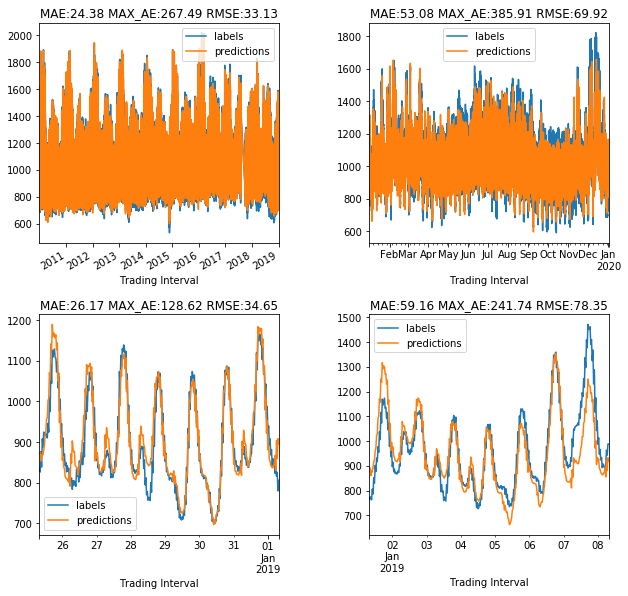

In [0]:
check_predictions(cat_boost, train_features, train_labels, val_features, val_labels, drop_columns=[])

In [0]:
feature_score1 = pd.DataFrame(list(zip(train_features.dtypes.index, cat_boost.get_feature_importance())),
                columns=['Feature','Score'])

feature_score1 = feature_score1.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

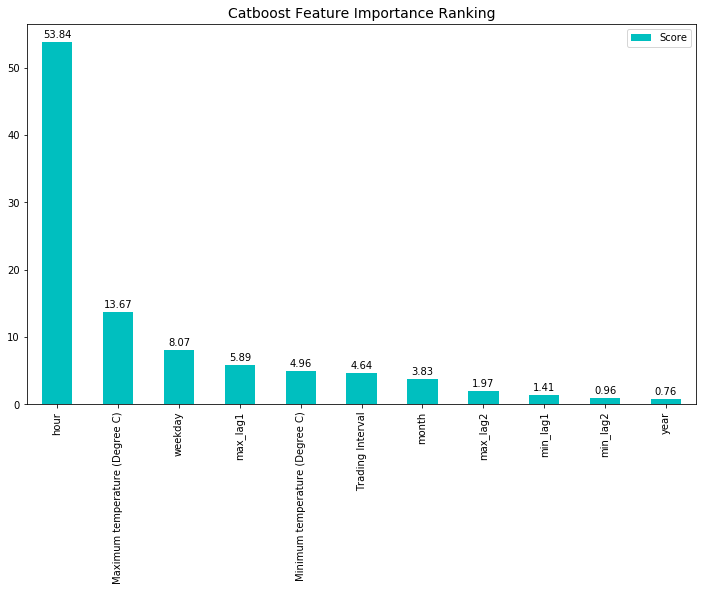

In [0]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score1.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score1['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [0]:
 %%time
cat_boost_1 = cg.CatBoostRegressor(loss_function='MAE', subsample = 0.8, rsm=0.8, learning_rate= 0.05, n_estimators=60).fit(train_features, train_labels, verbose=0)

CPU times: user 3.05 s, sys: 194 ms, total: 3.24 s
Wall time: 2.01 s


In [0]:
train_pred_ctb1 = cat_boost_1.predict(train_features)
print (mean_absolute_error(train_labels,train_pred_ctb1))

26.16835115563863


In [0]:
val_pred_ctb1 = cat_boost_1.predict(val_features)
print (mean_absolute_error(val_labels,val_pred_ctb1))

62.89693534268788


[**Playing with the parameters for xgboost**]


**changed parameters : learning_rate, n_estimators, subsample and colsample_bytree**

In [0]:
%%time
xg_reg_2 = xgb.XGBRegressor(objective ='reg:linear', learning_rate=0.05, n_estimators=60,subsample=0.8, colsample_bytree=0.8)
xg_reg_2.fit(train_features.drop('Trading Interval', axis=1), train_labels,)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[02:10:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3.54 s, sys: 16.8 ms, total: 3.55 s
Wall time: 3.56 s


In [0]:
val_preds_2 = xg_reg_2.predict(val_features.drop('Trading Interval', axis=1))
print ("MSE_test: ", mean_absolute_error(val_labels,val_preds_2))

MSE_test:  99.64035158599435


**increased learning rate and n_estimators. MSE seems to improve.**

In [0]:
%%time
xg_reg_4 = xgb.XGBRegressor(objective ='reg:linear', learning_rate=0.20, n_estimators=500,subsample=0.8, colsample_bytree=0.8)
xg_reg_4.fit(train_features.drop('Trading Interval', axis=1), train_labels,)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[02:14:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 26.3 s, sys: 68.1 ms, total: 26.3 s
Wall time: 26.4 s


In [0]:
val_preds_4 = xg_reg_4.predict(val_features.drop('Trading Interval', axis=1))
print ("MSE_test: ", mean_absolute_error(val_labels,val_preds_4))

MSE_test:  64.45081684636087


In [0]:
%%time
xg_reg_d = xgb.XGBRegressor(objective ='reg:linear',  n_estimators=1000)
xg_reg_d.fit(train_features.drop('Trading Interval', axis=1), train_labels,)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[02:17:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 48 s, sys: 139 ms, total: 48.1 s
Wall time: 48.2 s


In [0]:
val_preds_d = xg_reg_d.predict(val_features.drop('Trading Interval', axis=1))
print ("MSE_test: ", mean_absolute_error(val_labels,val_preds_d))

MSE_test:  64.45324636918299


In [0]:
%%time
xg_reg_5 = xgb.XGBRegressor(objective ='reg:linear', learning_rate=0.30, n_estimators=500,subsample=0.8, colsample_bytree=0.8)
xg_reg_5.fit(train_features, train_labels,)

**Randomized search for Xgboost with (2 * 3 * 2 * 5 ) = 60 combinations** 

In [0]:

%%time
params = {
        
        'learning_rate': [0.10,0.15],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [ 0.8, 1.0],
        'n_estimators':  [60,100,500, 1000,1500]
        }
search_1 = RandomizedSearchCV(estimator= xg_reg, param_distributions=params,cv=10,scoring=my_scorer,n_jobs=-1)
search_1.fit(train_features,train_labels)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[05:49:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5.11 s, sys: 355 ms, total: 5.46 s
Wall time: 30min 17s


In [0]:
val_pred_xg_rs = search_1.best_estimator_.predict(val_features)
mse_xg_rs = (mean_absolute_error(val_labels,val_pred_xg_rs))
print(mse_xg_rs)

87.20050490867021


**Grid search for Xgboost with (2 * 3 * 2 * 5 ) = 60 combinations**



In [0]:
%%time
params = {
        
        'learning_rate': [0.10,0.15],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [ 0.8, 1.0],
        'n_estimators':  [60,100,500, 1000,1500]
        }
search_2 = GridSearchCV(estimator= xg_reg, param_grid=params,cv=10,scoring=my_scorer,n_jobs=-1)
search_2.fit(train_features,train_labels)

In [0]:
search_1.best_estimator_,search_1.best_params_,search_1.best_score_

(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              importance_type='gain', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=60,
              n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1),
 {'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'n_estimators': 60,
  'subsample': 0.6},
 60.56005851561152)

In [0]:
%%time
xg_reg_bf = xgb.XGBRegressor(objective ='reg:linear',  n_estimators=60, colsample_bytree = 0.8, learning_rate= 0.1, subsample=0.6)
xg_reg_bf.fit(train_features.drop('Trading Interval', axis=1), train_labels,)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[02:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3.76 s, sys: 22.6 ms, total: 3.79 s
Wall time: 3.79 s


In [0]:
val_pred_xg_bf = xg_reg_bf.predict(val_features.drop('Trading Interval', axis=1))
mse_xg_bf = (mean_absolute_error(val_labels,val_pred_xg_bf))
print(mse_xg_bf)

87.20050490867021


**Playing with the parameters for Lightgbm**

In [0]:
 # fit a lightGBM model to the data
   %%time
   
   parameters = {
   
    'objective':'regression',
    'metric': 'mae',
     # 'feature_fraction': 1,
    #'bagging_fraction': 1,
    # 'learning_rate': 0.1,
     'n_estimators ':1000
    
}

l_model_2 = ltb.train(parameters,
                       train_data,
                       valid_sets=test_data, verbose_eval=False
                       
                      )
    
    
    

CPU times: user 2.07 s, sys: 20.8 ms, total: 2.09 s
Wall time: 1.06 s


In [0]:
%%time
train_pred_lgb_2 = l_model_2.predict(train_features)
print (mean_absolute_error(train_labels,train_pred_lgb_2))

40.24155571485714
CPU times: user 601 ms, sys: 1.22 ms, total: 602 ms
Wall time: 605 ms


In [0]:
# make predictions
%%time
    val_pred_lgb_2 = l_model_2.predict(val_features.drop('Trading Interval', axis=1))
print (mean_absolute_error(val_labels,val_pred_lgb_2))

57.01665567263015
CPU times: user 79.4 ms, sys: 2.94 ms, total: 82.4 ms
Wall time: 92.6 ms


**Randomized search for lightgbm with (2 * 3 * 2 * 5 ) = 60 combinations** 

In [0]:
%%time
lightgbm_params = {

        'bagging_fraction': (0.6,0.8, 1),
          'feature_fraction': (0.8, 0.10),
          'learning_Rate' : (0.10,0.15),
          'n_estimators ' :(60,100,500,1000,1500)


}

# Initialize a RandomizedSearchCV object using 5-fold CV-
ltb_cv = RandomizedSearchCV(estimator=ltb.LGBMRegressor(), param_distributions=lightgbm_params,  n_iter=100,verbose=1,scoring=my_scorer)

# Train on training data-
ltb_cv_fit = ltb_cv.fit(train_features, train_labels,verbose=1)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.2min finished


CPU times: user 4min 11s, sys: 2.15 s, total: 4min 13s
Wall time: 4min 14s


In [0]:
#data_dmatrix = xgb.DMatrix(data=train_features,label=train_labels)

In [0]:

%%time

#print(ltb_cv.best_params_, ltb_cv.best_score_)
ltb_cv.best_params_,ltb_cv.best_score_

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.2 µs


({'bagging_fraction': 0.6,
  'feature_fraction': 0.1,
  'learning_Rate': 0.1,
  'n_estimators ': 60},
 87.26736029692557)

In [0]:


%%time
train_ltb_cv_fit = ltb_cv_fit.predict(train_features)
print (mean_absolute_error(train_labels,train_ltb_cv_fit))

36.39324945518716
CPU times: user 651 ms, sys: 1.97 ms, total: 653 ms
Wall time: 656 ms


In [0]:
%%time
    val_ltb_cv_fit = ltb_cv_fit.predict(val_features)
print (mean_absolute_error(val_labels,val_ltb_cv_fit))

98.9050683995987
CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 74.4 ms




**Gridsearch with lightGBM**



In [0]:
%%time
lightgbm_params = {

        'bagging_fraction': (0.6,0.8, 1),
          'feature_fraction': (0.8, 0.10),
          'learning_Rate' : (0.10,0.15),
          'n_estimators ' :(60,100,500,1000,1500)


}

# Initialize a RandomizedSearchCV object using 5-fold CV-
ltb_grid = GridSearchCV(estimator=ltb.LGBMRegressor(), param_grid=lightgbm_params,scoring=my_scorer)

# Train on training data-
ltb_grid_fit = ltb_grid.fit(train_features.drop('Trading Interval', axis=1), train_labels,verbose=1)

CPU times: user 7min 37s, sys: 5.91 s, total: 7min 43s
Wall time: 4min 3s


In [0]:
%%time
    val_ltb_gs = ltb_grid.predict(val_features.drop('Trading Interval', axis=1))
print (mean_absolute_error(val_labels,val_ltb_gs))

98.9050683995987
CPU times: user 119 ms, sys: 904 µs, total: 120 ms
Wall time: 77.9 ms


**Gridsearch with catboost**

In [0]:
%%time
catboost_params = {

        'subsample': [0.6,0.8, 1],
          'rsm': [0.8, 0.10],
          'learning_rate' : [0.10,0.15],
          'iterations' :[60,100,500,1000,1500]


}

# Initialize a RandomizedSearchCV object using 5-fold CV-
#cb_grid = GridSearchCV(estimator=cg.CatBoostRegressor(eval_metric = 'RMSE'), param_grid=catboost_params,scoring=my_scorer)

# Train on training data-
#cb_grid_fit = cb_grid.fit(train_features, train_labels,verbose=1)
clf = cg.CatBoostRegressor( )
clf1=GridSearchCV(estimator=clf, param_grid = catboost_params, cv = 5, n_jobs=-1)

clf1_fit = clf1.fit(train_features, train_labels)

0:	learn: 187.0293162	total: 73ms	remaining: 1m 12s
1:	learn: 175.2793732	total: 95.5ms	remaining: 47.6s
2:	learn: 164.8635836	total: 118ms	remaining: 39.1s
3:	learn: 155.9505864	total: 140ms	remaining: 34.8s
4:	learn: 147.9871254	total: 163ms	remaining: 32.5s
5:	learn: 141.1437438	total: 186ms	remaining: 30.8s
6:	learn: 134.7028534	total: 209ms	remaining: 29.6s
7:	learn: 128.9203810	total: 230ms	remaining: 28.5s
8:	learn: 123.7009269	total: 253ms	remaining: 27.8s
9:	learn: 119.1404761	total: 280ms	remaining: 27.7s
10:	learn: 115.4213422	total: 303ms	remaining: 27.2s
11:	learn: 111.8660835	total: 324ms	remaining: 26.7s
12:	learn: 108.7084277	total: 346ms	remaining: 26.2s
13:	learn: 105.7359543	total: 368ms	remaining: 25.9s
14:	learn: 102.8581146	total: 390ms	remaining: 25.6s
15:	learn: 100.4338398	total: 412ms	remaining: 25.4s
16:	learn: 97.6317772	total: 435ms	remaining: 25.1s
17:	learn: 95.5754355	total: 456ms	remaining: 24.9s
18:	learn: 93.6814361	total: 478ms	remaining: 24.7s
19:	l

In [0]:
clf1.best_params_,clf1.best_score_

({'iterations': 1000, 'learning_rate': 0.1, 'rsm': 0.8, 'subsample': 0.6},
 0.896148838237034)

In [0]:
val_clf_bf = clf1.predict(val_features)
print (mean_absolute_error(val_labels,val_clf_bf))


51.82448776442693


**Randomized search with catboost**

In [0]:
%%time
# model = CatBoost()
# model.fit(train_features, train_labels)
# grid = {'subsample': [0.6,0.8, 1],
#           'rsm': [0.8, 0.10],
#           'learning_rate' : [0.10,0.15],
#           'iterations' :[60,100,500,1000,1500]
# }

# randomized_search_result = model.randomized_search(grid,
#                                                    X=train_features,
#                                                    y=train_labels,
#                                                    plot=True)

clf = cg.CatBoostRegressor( )
clf2=RandomizedSearchCV(estimator=clf, param_distributions = catboost_params, cv = 5, n_jobs=-1)

clf2_fit = clf2.fit(train_features, train_labels)

0:	learn: 180.5779279	total: 28.7ms	remaining: 28.7s
1:	learn: 164.2964191	total: 53.9ms	remaining: 26.9s
2:	learn: 151.0322853	total: 79.3ms	remaining: 26.4s
3:	learn: 140.3304688	total: 103ms	remaining: 25.7s
4:	learn: 131.1803295	total: 128ms	remaining: 25.4s
5:	learn: 123.4620226	total: 152ms	remaining: 25.2s
6:	learn: 116.6707632	total: 175ms	remaining: 24.9s
7:	learn: 110.5029583	total: 202ms	remaining: 25s
8:	learn: 105.9797533	total: 240ms	remaining: 26.5s
9:	learn: 101.9525372	total: 264ms	remaining: 26.1s
10:	learn: 98.6239848	total: 288ms	remaining: 25.9s
11:	learn: 94.6995866	total: 313ms	remaining: 25.8s
12:	learn: 91.7964809	total: 337ms	remaining: 25.6s
13:	learn: 89.1929021	total: 361ms	remaining: 25.4s
14:	learn: 87.2435616	total: 384ms	remaining: 25.2s
15:	learn: 84.8046319	total: 409ms	remaining: 25.2s
16:	learn: 83.0746150	total: 432ms	remaining: 25s
17:	learn: 81.6335754	total: 458ms	remaining: 25s
18:	learn: 79.9057749	total: 482ms	remaining: 24.9s
19:	learn: 78.4

In [0]:
clf2.best_params_,clf2.best_score_

({'iterations': 1000, 'learning_rate': 0.15, 'rsm': 0.8, 'subsample': 0.6},
 0.8830272480718637)

In [0]:
val_clf_fit2 = clf2.predict(val_features)
print (mean_absolute_error(val_labels,val_clf_fit2))

54.10543670415147


**Introducing categorical features**

lightgbm

In [0]:
train_features1=train_features.copy()
val_features1=val_features.copy()

s.

In [0]:
train_features1.tail(5)


,Trading Interval,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2
154795,2019-01-01 05:30:00,5.5,1,1,2019,34.1,16.3,32.2,13.9,29.7,11.7
154796,2019-01-01 06:00:00,6.0,1,1,2019,34.1,16.3,32.2,13.9,29.7,11.7
154797,2019-01-01 06:30:00,6.5,1,1,2019,34.1,16.3,32.2,13.9,29.7,11.7
154798,2019-01-01 07:00:00,7.0,1,1,2019,34.1,16.3,32.2,13.9,29.7,11.7
154799,2019-01-01 07:30:00,7.5,1,1,2019,34.1,16.3,32.2,13.9,29.7,11.7


In [0]:
train_features1['month'] = train_features1['month'].astype('category')
train_features1['hour'] = train_features1['hour'].astype('category')
train_features1['weekday'] = train_features1['weekday'] .astype('category')

val_features1['month'] = val_features1['month'].astype('category')
val_features1['hour'] = val_features1['hour'] .astype('category')
val_features1['weekday'] = val_features1['weekday'].astype('category')

# from sklearn import preprocessing
# lbl = preprocessing.LabelEncoder()
# train_features1['month'] = lbl.fit_transform(train_features1['month'].astype(str))
# train_features1['hour'] = lbl.fit_transform(train_features1['hour'].astype(str))
# train_features1['weekday'] = lbl.fit_transform(train_features1['weekday'].astype(str))


# val_features1['month'] = lbl.fit_transform(val_features1['month'].astype(str))
# val_features1['hour'] = lbl.fit_transform(val_features1['hour'].astype(str))
# val_features1['weekday'] = lbl.fit_transform(val_features1['weekday'].astype(str))



In [0]:
categorical_features = ["month", "hour","weekday"]

In [0]:
train_features1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154800 entries, 0 to 154799
Data columns (total 11 columns):
Trading Interval                  154800 non-null datetime64[ns]
hour                              154800 non-null category
weekday                           154800 non-null category
month                             154800 non-null category
year                              154800 non-null int64
Maximum temperature (Degree C)    154800 non-null float64
Minimum temperature (Degree C)    154800 non-null float64
max_lag1                          154800 non-null float64
min_lag1                          154800 non-null float64
max_lag2                          154800 non-null float64
min_lag2                          154800 non-null float64
dtypes: category(3), datetime64[ns](1), float64(6), int64(1)
memory usage: 11.1 MB


In [0]:
#val_features1['month'] = val_features1.astype('category')
#val_features1['hour'] = val_features1.astype('category')
#val_features1['weekday'] = val_features1.astype('category')

In [0]:
train_data1 = ltb.Dataset(train_features1.drop('Trading Interval', axis=1), label=train_labels,categorical_feature=categorical_features,free_raw_data= False)
test_data1 = ltb.Dataset(val_features1.drop('Trading Interval', axis=1), label=val_labels,categorical_feature=categorical_features, free_raw_data= False)

In [0]:
%%time
parameters = {
   
    'objective':'regression',
    'metric': 'mae',
     'boosting': 'gbdt',
     'feature_fraction': 1,
    'bagging_fraction': 1,
    'learning_rate': 0.1,
    'n_estimators' :1000,
   'categorical_feature' :   categorical_features 
  
    
}

l_model_cf = ltb.train(parameters,
                       train_data1,
                       valid_sets=test_data1  , verbose_eval=False
                        #categorical_feature=categorical_features
                       )

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


CPU times: user 14.6 s, sys: 199 ms, total: 14.8 s
Wall time: 7.52 s


In [0]:
%%time
    val_pred_lgb_cf = l_model_cf.predict(val_features1.drop('Trading Interval', axis=1))
print (mean_absolute_error(val_labels,val_pred_lgb_cf))

50.24081736535503
CPU times: user 1.38 s, sys: 1.79 ms, total: 1.38 s
Wall time: 715 ms


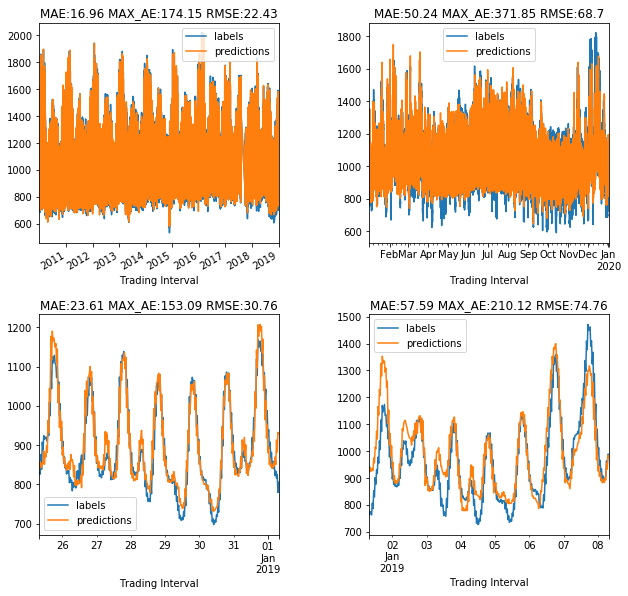

In [0]:
check_predictions(l_model_cf, train_features1, train_labels, val_features1, val_labels)

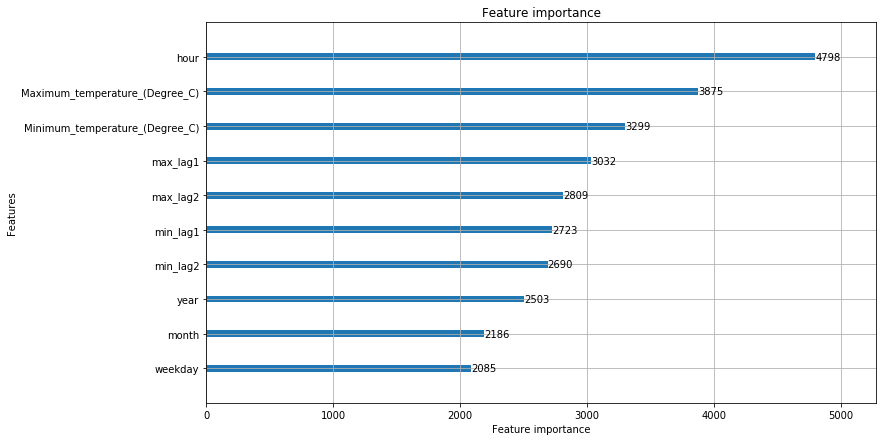

In [0]:
ltb.plot_importance(l_model_cf)

In [0]:
# %%time
# solar_output = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1LKKPydF9Owcof9z2hSWjNQjQiy-tCLYa&export=download')
# solar_output = solar_output[['Year','Month','Day','Daily global solar exposure (MJ/m*m)']]
# df.insert(len(df.columns), 'day', df['Trading Interval'].dt.day)
# df = df.merge(solar_output, left_on=['year','month','day'], right_on=['Year','Month','Day']).drop(['day', 'Year', 'Month', 'Day'], axis=1)

# [rf,xg_reg, train_features, train_labels, val_features, val_labels] = train_forest(df.drop('Trading Interval', axis=1), 365*48)

In [0]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]
categorical_features_pos = column_index(train_features1, categorical_features)

In [0]:
#  %%time
# cat_boost_cf = cg.CatBoostRegressor(loss_function='MAE', subsample = 0.8,  learning_rate= 0.20, n_estimators=500).fit(train_features1, train_labels, cat_features=categorical_features_pos)

In [0]:
train_features1.isnull().sum()

Trading Interval                  0
hour                              0
weekday                           0
month                             0
year                              0
Maximum temperature (Degree C)    0
Minimum temperature (Degree C)    0
max_lag1                          0
min_lag1                          0
max_lag2                          0
min_lag2                          0
dtype: int64

In [0]:
categorical_features_pos

array([3, 1, 2])

Categorical features with Catboost

In [0]:
# val_pred_ctb_cf = cat_boost_cf.predict(val_features)
# print (mean_absolute_error(val_labels,val_pred_ctb_cf))

165.72048121598286


In [0]:
train_features2=train_features.copy()
val_features2=val_features.copy()

In [0]:
#val_features2['hour'].astype('str')

In [0]:
val_features2.tail(5)

,Trading Interval,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2
172315,2020-01-01 05:30:00,5.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172316,2020-01-01 06:00:00,6.0,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172317,2020-01-01 06:30:00,6.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172318,2020-01-01 07:00:00,7.0,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172319,2020-01-01 07:30:00,7.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9


In [0]:
train_features2['month'] = train_features2['month'].astype('str')
train_features2['hour'] = train_features2['hour'].astype('str')
train_features2['weekday'] = train_features2['weekday'] .astype('str')

val_features2['month'] = val_features2['month'].astype('str')
val_features2['hour'] = val_features2['hour'] .astype('str')
val_features2['weekday'] = val_features2['weekday'].astype('str')

In [0]:
val_features2.tail(5)

,Trading Interval,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2
172315,2020-01-01 05:30:00,5.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172316,2020-01-01 06:00:00,6.0,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172317,2020-01-01 06:30:00,6.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172318,2020-01-01 07:00:00,7.0,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172319,2020-01-01 07:30:00,7.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9


In [0]:
train_features2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154800 entries, 0 to 154799
Data columns (total 11 columns):
Trading Interval                  154800 non-null datetime64[ns]
hour                              154800 non-null object
weekday                           154800 non-null object
month                             154800 non-null object
year                              154800 non-null int64
Maximum temperature (Degree C)    154800 non-null float64
Minimum temperature (Degree C)    154800 non-null float64
max_lag1                          154800 non-null float64
min_lag1                          154800 non-null float64
max_lag2                          154800 non-null float64
min_lag2                          154800 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 14.2+ MB


In [0]:
categorical_features_pos1 = column_index(train_features2, categorical_features)

In [0]:
%%time
cat_boost_cf1 = cg.CatBoostRegressor(loss_function='MAE')#, subsample = 1,  learning_rate= 0.1, n_estimators=100)
cat_boost_cf1.fit(train_features2, train_labels, cat_features=categorical_features_pos1, verbose = False)

CPU times: user 2min 54s, sys: 11.4 s, total: 3min 5s
Wall time: 1min 40s


In [0]:
val_pred_ctb_cf1 = cat_boost_cf1.predict(val_features2)
print (mean_absolute_error(val_labels,val_pred_ctb_cf1))

58.862826990569


In [0]:
val_features.tail(10)

,Trading Interval,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2
172310,2020-01-01 03:00:00,3.0,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172311,2020-01-01 03:30:00,3.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172312,2020-01-01 04:00:00,4.0,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172313,2020-01-01 04:30:00,4.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172314,2020-01-01 05:00:00,5.0,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172315,2020-01-01 05:30:00,5.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172316,2020-01-01 06:00:00,6.0,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172317,2020-01-01 06:30:00,6.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172318,2020-01-01 07:00:00,7.0,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9
172319,2020-01-01 07:30:00,7.5,2,1,2020,31.9,15.3,30.8,12.7,26.2,13.9


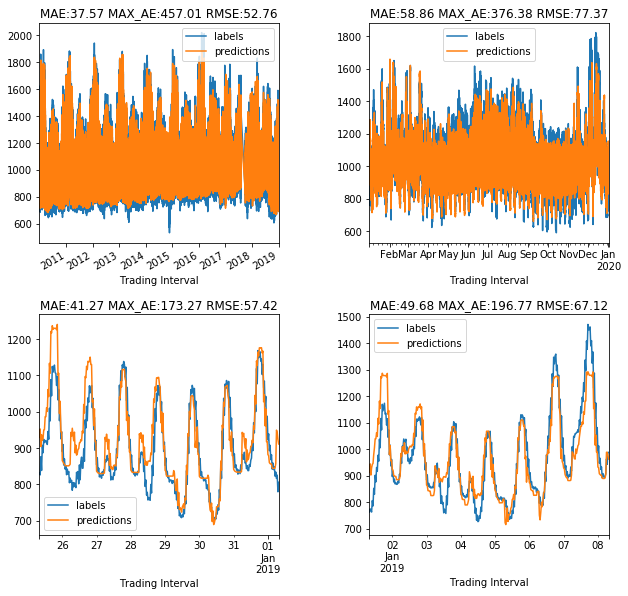

In [0]:
check_predictions(cat_boost_cf1, train_features2, train_labels, val_features2, val_labels,drop_columns=[])

In [0]:
feat_imp=cat_boost_cf1.get_feature_importance()

In [0]:
feature_score = pd.DataFrame(list(zip(train_features2.dtypes.index, cat_boost_cf1.get_feature_importance())),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

In [0]:
feature_score

,Feature,Score
1,hour,39.416311
5,Maximum temperature (Degree C),16.459510
2,weekday,10.949956
7,max_lag1,8.680304
3,month,7.240017
6,Minimum temperature (Degree C),6.953705
0,Trading Interval,6.091282
9,max_lag2,1.638490
8,min_lag1,1.131532
4,year,0.814806


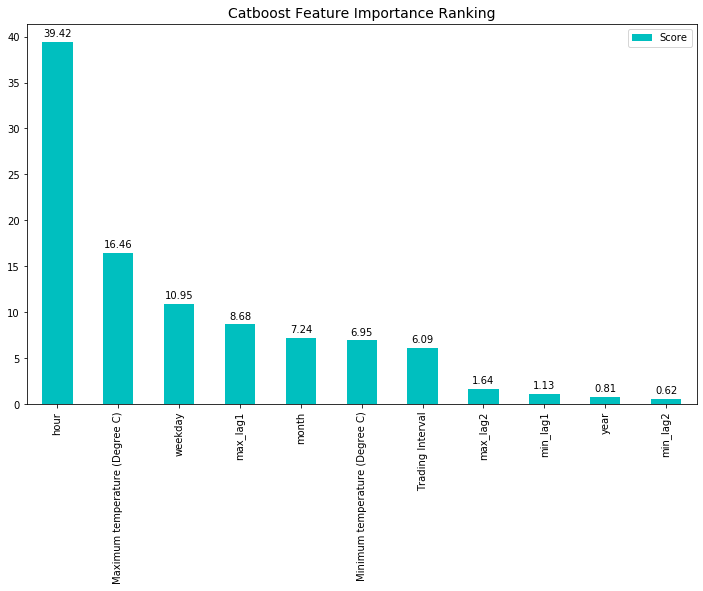

In [0]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [0]:
from sklearn.grid_search import ParameterGrid